In [1]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
import os

for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/B005SUHPO6.csv
../data/B005SUHPO6_test_set.csv
../data/B005SUHPO6_train_set.csv
../data/B0090AAOUW.csv
../data/B00KROF20M.csv


In [3]:
data = pd.read_csv('../data/B005SUHPO6.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18688 entries, 0 to 18687
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      18688 non-null  int64  
 1   reviewerID      18688 non-null  object 
 2   asin            18688 non-null  object 
 3   reviewerName    18685 non-null  object 
 4   helpful         18688 non-null  object 
 5   reviewText      18684 non-null  object 
 6   overall         18688 non-null  float64
 7   summary         18688 non-null  object 
 8   unixReviewTime  18688 non-null  int64  
 9   reviewTime      18688 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 1.4+ MB


In [4]:
data.columns = map(str.lower, data.columns)
data_reviews = data[['reviewtext']]
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18688 entries, 0 to 18687
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewtext  18684 non-null  object
dtypes: object(1)
memory usage: 146.1+ KB


In [5]:
review_text_sample = data_reviews.sample(5000).values.tolist()

In [6]:
review_text_sample[6]

["What can i say, i've dropped my phone more than a few times, so far it hasn't let me down. It is a little bulky, but that's to be expected, it's to protect your phone. I bought two of these and both phones are still surviving. You can easily get to any of the buttons on the phone without removing it. I would definately buy it again."]

In [7]:
def tokenize(texts):
    for text in texts:
        yield(simple_preprocess(str(text),deacc=True))

In [8]:
review_text_token = list(tokenize(review_text_sample))

In [9]:
print(review_text_sample[6])
print(review_text_token[6])

["What can i say, i've dropped my phone more than a few times, so far it hasn't let me down. It is a little bulky, but that's to be expected, it's to protect your phone. I bought two of these and both phones are still surviving. You can easily get to any of the buttons on the phone without removing it. I would definately buy it again."]
['what', 'can', 'say', 've', 'dropped', 'my', 'phone', 'more', 'than', 'few', 'times', 'so', 'far', 'it', 'hasn', 'let', 'me', 'down', 'it', 'is', 'little', 'bulky', 'but', 'that', 'to', 'be', 'expected', 'it', 'to', 'protect', 'your', 'phone', 'bought', 'two', 'of', 'these', 'and', 'both', 'phones', 'are', 'still', 'surviving', 'you', 'can', 'easily', 'get', 'to', 'any', 'of', 'the', 'buttons', 'on', 'the', 'phone', 'without', 'removing', 'it', 'would', 'definately', 'buy', 'it', 'again']


In [10]:
# remove stopwords
stop_words=stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in text if word not in stop_words] for text in texts]

review_text_token_nostops = remove_stopwords(review_text_token)

In [11]:
print(review_text_token_nostops[6])

['say', 'dropped', 'phone', 'times', 'far', 'let', 'little', 'bulky', 'expected', 'protect', 'phone', 'bought', 'two', 'phones', 'still', 'surviving', 'easily', 'get', 'buttons', 'phone', 'without', 'removing', 'would', 'definately', 'buy']


In [12]:
# Applying Bigrams and trigrams 
def make_bigram(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    return [bigram_mod[doc] for doc in texts]

review_text_bigrams = make_bigram(review_text_token_nostops)

In [13]:
print(review_text_bigrams[6])

['say', 'dropped', 'phone', 'times', 'far', 'let', 'little', 'bulky', 'expected', 'protect', 'phone', 'bought', 'two', 'phones', 'still', 'surviving', 'easily', 'get', 'buttons', 'phone', 'without', 'removing', 'would', 'definately', 'buy']


In [14]:
#lemmatize
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
data_lemmatized = lemmatization(review_text_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
print(data_lemmatized[6])

['say', 'drop', 'phone', 'time', 'far', 'let', 'little', 'bulky', 'expect', 'protect', 'phone', 'buy', 'phone', 'still', 'survive', 'easily', 'get', 'button', 'phone', 'remove', 'would', 'definately', 'buy']


##### Create Dictionary

In [17]:
dictionary = corpora.Dictionary(data_lemmatized)
print(dictionary.num_nnz)

98506


In [18]:
dictionary[0]

'adult'

##### Create document term matrix

In [19]:
corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]
print(len(corpus))

5000


##### Build LDA model

##### Visualize the topics

##### Find the optimal number of topics for LDA

In [20]:
def compute_coherence(corpus, dictionary, texts, chunk_size, topics_range, nkeywords):
    model_list = {}
    model_coherence = {}
    model_topics = {}
#     topics_range = list(range(start, limit, step)) # create number of topics range list
    lda = gensim.models.ldamodel.LdaModel # instantiate LDA model
    
    for i in range(len(topics_range)):
        num_topics = topics_range[i]
        model_list[i] = lda(corpus=corpus, id2word=dictionary, num_topics=num_topics, update_every=1, chunksize=chunk_size, passes=10, alpha='auto', random_state=42, per_word_topics=True)
        coherencemodel = CoherenceModel(model=model_list[i], texts=texts, dictionary=dictionary, coherence='c_v')
        model_coherence[i] = coherencemodel.get_coherence()
        shown_topics = model_list[i].show_topics(num_topics=num_topics, num_words=nkeywords, formatted=False)
        model_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
    return model_list, model_coherence, model_topics

In [21]:
def compute_jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [22]:
def compute_mean_stability(topics, topics_range):
    """
    derive the mean stability across topics by considering the next topic
    """
    stability_scores = {}
    mean_stabilities = {}

    for i in range(0, len(topics_range)-1):
        score = []
        for t1, topic1 in enumerate(model_topics[i]):
            jaccard_score = []
            for t2, topic2 in enumerate(model_topics[i+1]):
                jaccard_score.append(compute_jaccard_similarity(topic1, topic2))

            score.append(jaccard_score)

        stability_scores[i] = score
        mean_stabilities[i] = np.array(stability_scores[i]).mean()
    
    return mean_stabilities

In [23]:
n_start=2
n_limit=35
n_step=3
n_words = 10
topics_range = list(range(n_start, n_limit, n_step)) # create number of topics range list
chunk_size = len(corpus)

model_list, coherence_values, model_topics = compute_coherence(corpus=corpus, dictionary=dictionary, 
                                                               texts=data_lemmatized, chunk_size=chunk_size, 
                                                               topics_range=topics_range, nkeywords=n_words)

mean_stabilities = compute_mean_stability(topics=model_topics, topics_range=topics_range)

In [24]:
diff_coherence_stability = []
y_coherence_values = []
y_mean_stabilities = []
for i in range(0, len(topics_range)-1):
    diff_coherence_stability.append(coherence_values[i] - mean_stabilities[i])
    y_coherence_values.append(coherence_values[i])
    y_mean_stabilities.append(mean_stabilities[i])
    
#     print('Coherence value: {} | Stability(mean): {} | {}'.format(round(coherence_values[i], 2), round(mean_stabilities[i], 2), round(diff_coherence_stability[i], 3)))

derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics:

In [25]:
max_diff_val = max(diff_coherence_stability)
max_diff_idx = diff_coherence_stability.index(max_diff_val)
ideal_num_topics = topics_range[max_diff_idx]

print('Ideal number of topics for model selection is {}'.format(ideal_num_topics))

Ideal number of topics for model selection is 26


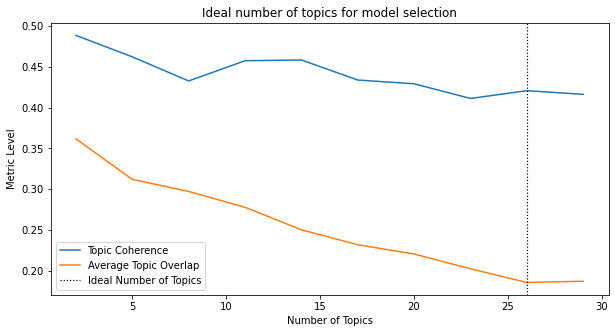

In [26]:
%matplotlib inline
plt.figure(figsize=(10, 5))
x_topics_range = topics_range[:-1]

plt.plot(x_topics_range, y_coherence_values, label = 'Topic Coherence')
plt.plot(x_topics_range, y_mean_stabilities, label = 'Average Topic Overlap')
plt.axvline(x = ideal_num_topics, label='Ideal Number of Topics', color='black', linestyle = ':', linewidth=1.2)
plt.legend()
plt.xlabel('Number of Topics')
plt.ylabel('Metric Level')
plt.title('Ideal number of topics for model selection')
plt.show()

##### References
- https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://www.kaggle.com/madhavi11089/topicmodelling-with-lda
- https://github.com/raaga500/YTshared/blob/master/V4_TopicModelling_4.ipynb